# Statistical vs ML IDS — Wednesday DoS variants
This notebook builds a simple, defensible comparison between a statistical baseline (z-score) and an ML detector (Isolation Forest). We avoid data leakage by fitting only on benign windows and holding out the end of the trace for testing.

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
import time

plt.rcParams["figure.dpi"] = 120

## Load data

In [15]:
df = pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv", low_memory=False)
print("Raw rows, cols:", df.shape)

Raw rows, cols: (692703, 79)


## Timestamp, feature engineering, and selection

In [16]:
# Clean header whitespace and synthesize timestamps because the CICIDS trace lacks a steady index
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.date_range(start="2017-07-07 15:00:00", periods=len(df), freq="10ms")
df = df.set_index('Timestamp')

# Simple interpretable volume indicators
df['packets'] = df['Total Fwd Packets'] + df['Total Backward Packets']
df['bytes']   = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']

keep = [
    'packets', 'bytes',
    'Destination Port',
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
    'Min Packet Length', 'Max Packet Length',
    'SYN Flag Count', 'ACK Flag Count', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ECE Flag Count',
    'Subflow Fwd Packets', 'Subflow Bwd Packets',
    'Label'
]

df = df[keep]
df.head()

,packets,bytes,Destination Port,Packet Length Mean,Packet Length Std,Packet Length Variance,Min Packet Length,Max Packet Length,SYN Flag Count,ACK Flag Count,FIN Flag Count,RST Flag Count,PSH Flag Count,ECE Flag Count,Subflow Fwd Packets,Subflow Bwd Packets,Label
Timestamp,,,,,,,,,,,,,,,,,
2017-07-07 15:00:00.000,2,12,80,6.000000,0.000000,0.000000,6,6,0,1,0,0,0,0,1,1,BENIGN
2017-07-07 15:00:00.010,16,498,389,29.294118,56.529599,3195.595588,0,163,0,0,0,0,1,0,11,5,BENIGN
2017-07-07 15:00:00.020,16,6300,88,370.588235,671.751541,451250.132400,0,1575,0,0,0,0,1,0,10,6,BENIGN
2017-07-07 15:00:00.030,29,10112,389,337.066667,704.654082,496537.374700,0,3069,0,0,0,0,1,0,17,12,BENIGN
2017-07-07 15:00:00.040,15,6302,88,393.875000,704.585067,496440.116700,0,1576,0,0,0,0,1,0,9,6,BENIGN


## Aggregate into 5s windows and derive ground truth

In [17]:
agg = df.resample("5s").agg({
    'packets':'sum', 'bytes':'sum', 'Destination Port':'nunique',
    'Packet Length Mean':'mean', 'Packet Length Std':'mean', 'Packet Length Variance':'mean',
    'Min Packet Length':'mean', 'Max Packet Length':'mean',
    'SYN Flag Count':'sum', 'ACK Flag Count':'sum', 'FIN Flag Count':'sum', 'RST Flag Count':'sum', 'PSH Flag Count':'sum', 'ECE Flag Count':'sum',
    'Subflow Fwd Packets':'sum', 'Subflow Bwd Packets':'sum',
    # Fraction of flows in the window that are *not* benign
    'Label': lambda x: (x != 'BENIGN').mean()
})

agg['is_attack'] = (agg['Label'] > 0.5).astype(int)
agg = agg.drop(columns=['Label'])
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)
print(agg[['is_attack']].value_counts(normalize=True, dropna=False))

is_attack
0            0.630592
1            0.369408
Name: proportion, dtype: float64


## Train/test split without temporal leakage
We keep ordering intact and start the test set at the last 20% of attack-labelled windows so the evaluation actually contains positives; models are still fit only on benign windows from the training side.


In [18]:
# Hold out the *end* of the attack period so the test set contains positives
attack_windows = agg.index[agg['is_attack'] == 1]
if len(attack_windows) == 0:
    raise ValueError("No attack-labelled windows found; cannot build split")

# Use last 20% of attack windows (plus the benign tail) as test
test_start = attack_windows[int(len(attack_windows) * 0.8)]
# keep order: everything strictly before test_start is train
train = agg.loc[:test_start - pd.Timedelta(seconds=5)]
test = agg.loc[test_start:]

benign_train = train[train['is_attack'] == 0].copy()
print(
    f"Windows train={len(train)}, test={len(test)}, "
    f"train_attacks={train['is_attack'].sum()}, test_attacks={test['is_attack'].sum()}, "
    f"benign_for_fit={len(benign_train)}"
)

Windows train=545, test=841, train_attacks=409, test_attacks=103, benign_for_fit=136


## Statistical baseline: robust z-score

In [19]:
Z_COLS = [
    'packets', 'bytes',
    'Packet Length Mean', 'Packet Length Std',
    'SYN Flag Count', 'ACK Flag Count'
]
train_mean = benign_train[Z_COLS].mean()
train_std = benign_train[Z_COLS].std(ddof=0).replace(0, 1)

agg['z_score'] = ((agg[Z_COLS] - train_mean) / train_std).abs().sum(axis=1)
# Threshold picked from benign-only distribution (99th percentile) to keep low false positives
z_threshold = agg.loc[benign_train.index, 'z_score'].quantile(0.99)
agg['z_anomaly'] = (agg['z_score'] > z_threshold).astype(int)


## ML baseline: Isolation Forest (fit on benign windows)

In [20]:
dos_features = [
    'packets', 'bytes', 'Packet Length Mean', 'Packet Length Std',
    'SYN Flag Count', 'ACK Flag Count', 'FIN Flag Count', 'RST Flag Count'
]

scaler = StandardScaler()
X_train = scaler.fit_transform(benign_train[dos_features])

iso = IsolationForest(
    contamination=0.02,
    n_estimators=300,
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train)

agg['if_anomaly'] = iso.predict(scaler.transform(agg[dos_features]))
agg['if_anomaly'] = (agg['if_anomaly'] == -1).astype(int)

## Evaluation on held-out test tail

In [21]:
def evaluate(name: str, column: str):
    y_true = test['is_attack']
    y_pred = agg.loc[test.index, column]
    print(f"=== {name} (test) ===")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))
    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

metrics = {
    'zscore': evaluate('Z-score', 'z_anomaly'),
    'isolation_forest': evaluate('Isolation Forest', 'if_anomaly')
}

=== Z-score (test) ===
              precision    recall  f1-score   support

           0      0.944     1.000     0.971       738
           1      1.000     0.573     0.728       103

    accuracy                          0.948       841
   macro avg      0.972     0.786     0.850       841
weighted avg      0.951     0.948     0.941       841

=== Isolation Forest (test) ===
              precision    recall  f1-score   support

           0      0.941     1.000     0.970       738
           1      1.000     0.553     0.713       103

    accuracy                          0.945       841
   macro avg      0.971     0.777     0.841       841
weighted avg      0.949     0.945     0.938       841



## Visualize detections

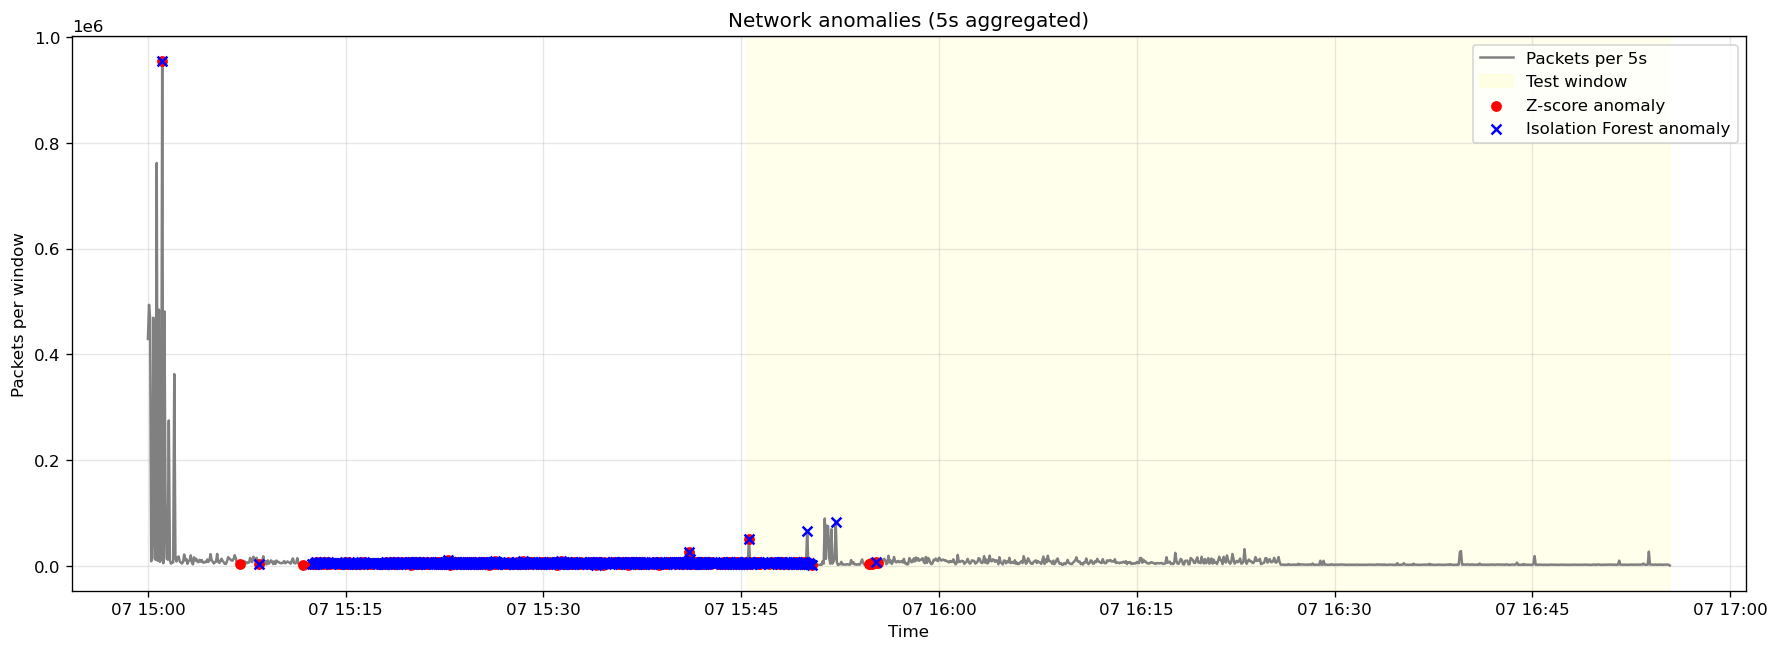

In [22]:
plt.figure(figsize=(18, 6))
plt.plot(agg.index, agg['packets'], color='grey', label='Packets per 5s')
plt.axvspan(test.index[0], test.index[-1], color='yellow', alpha=0.08, label='Test window')

plt.scatter(agg.index[agg['z_anomaly'] == 1], agg['packets'][agg['z_anomaly'] == 1],
            color='red', s=30, label='Z-score anomaly', zorder=3)
plt.scatter(agg.index[agg['if_anomaly'] == 1], agg['packets'][agg['if_anomaly'] == 1],
            color='blue', s=35, marker='x', label='Isolation Forest anomaly', zorder=4)

plt.title("Network anomalies (5s aggregated)")
plt.xlabel("Time")
plt.ylabel("Packets per window")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Streaming-style alerts

In [23]:
print("=== Real-time style alerts (prints only detected windows) ===")
for ts, row in agg.iterrows():
    if row['if_anomaly'] or row['z_anomaly']:
        print(
            f"[ALERT] {ts} | packets={row['packets']} | ports={row['Destination Port']} | "
            f"SYN={row['SYN Flag Count']} | attack={row['is_attack']} | IF={row['if_anomaly']} | Z={row['z_anomaly']}"
        )
        time.sleep(0.02)

=== Real-time style alerts (prints only detected windows) ===
[ALERT] 2017-07-07 15:01:05 | packets=954045.0 | ports=76.0 | SYN=37.0 | attack=0.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:07:00 | packets=3264.0 | ports=107.0 | SYN=321.0 | attack=1.0 | IF=0.0 | Z=1.0
[ALERT] 2017-07-07 15:08:25 | packets=4189.0 | ports=139.0 | SYN=237.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:11:45 | packets=2561.0 | ports=5.0 | SYN=280.0 | attack=1.0 | IF=0.0 | Z=1.0
[ALERT] 2017-07-07 15:12:25 | packets=2723.0 | ports=1.0 | SYN=145.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:12:30 | packets=3532.0 | ports=3.0 | SYN=0.0 | attack=1.0 | IF=0.0 | Z=1.0
[ALERT] 2017-07-07 15:12:35 | packets=4054.0 | ports=1.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:12:40 | packets=6142.0 | ports=1.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:12:45 | packets=6586.0 | ports=2.0 | SYN=0.0 | attack=1.0 | IF=1.0 | Z=1.0
[ALERT] 2017-07-07 15:12:50 | packets=3518.0 | po